### Main Notebook for visualisation 

Setup for required libraries:

In [1]:
%pip install numpy pandas matplotlib keras scikit-learn tensorflow


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Importing data for DNN training (using Pandas):

In [135]:
import pandas as pd
import numpy as np

file_path = 'dtag/grid/4_agents/4/velocity_metrics.csv'
file_path2 = 'dtag/grid/4_agents/4/idleness.csv'
file_path3 = 'dtag/grid/4_agents/4/vulnerabilities.csv'
file_path4 = 'dtag/grid/4_agents/4/distance_metrics.csv'


df_vel = pd.read_csv(file_path, sep=';', header=None)
df_idle = pd.read_csv(file_path2, sep=';',header=None)
df_vuln = pd.read_csv(file_path3, sep=';',header=None)
df_dist = pd.read_csv(file_path4, sep=';',header=None)



In [136]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, LSTM
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
tf.random.set_seed(7)

For all nodes:

In [152]:
N = len(df_vel.T)-1

vel_data = df_vel.iloc[:, 1:N+1]
idle_data = df_idle.iloc[:, 1:N+1]
idle_data[idle_data < 0] = np.nan

vuln_data = df_vuln.iloc[:, 1:N+1]
dist_data = df_dist.iloc[:, 1:N+1]

df = pd.concat([vel_data,idle_data,dist_data,vuln_data],axis=1)
df = df.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values
df = df.dropna()

threshold = 50

for col in range(N*3,N*4):

    df.iloc[df.iloc[:, col] < threshold, col] = 0
    df.iloc[df.iloc[:, col] >= threshold, col] = 1
df.iloc[:,75:100]



/var/folders/b5/lyr1nzqx4kq7mbz3wsnfsxcw0000gn/T/ipykernel_7733/3979858448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idle_data[idle_data < 0] = np.nan
/var/folders/b5/lyr1nzqx4kq7mbz3wsnfsxcw0000gn/T/ipykernel_7733/3979858448.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idle_data[idle_data < 0] = np.nan


,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
154,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
155,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
156,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
157,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
158,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21391,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
21392,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
21393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
21394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


Train and test split:

In [154]:
dataset = df.to_numpy()
# dataset[2] = scaler.fit_transform(dataset[2])


# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
df.iloc[:,75:100].value_counts()
# df.iloc[:,75:100]
# df.iloc[:,50:75]




14869 6373


1    2    3    4    5    6    7    8    9    10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25 
0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0    87
          1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0    84
          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0    76
          1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0    66
                                        1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    64
                                                                                                                               ..
                    0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0

In [168]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0:-N]
		dataX.append(a)
		dataY.append(dataset[i + look_back, N*3:N*4])
	return np.array(dataX), np.array(dataY)

look_back = 50

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainY.shape)

(14818, 25)


In [169]:
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[-1]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[-1]))
# trainY = np.reshape(trainY, (trainY.shape[0], 1, trainY.shape[-1]))
# testY = np.reshape(testY, (testY.shape[0], 1, testY.shape[-1]))

trainY.shape


(14818, 25)

In [171]:
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, trainX.shape[-1])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10


ValueError: in user code:

    File "/Users/alexbott/4th Year local/Intelligent-Intruder/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/alexbott/4th Year local/Intelligent-Intruder/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/alexbott/4th Year local/Intelligent-Intruder/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/alexbott/4th Year local/Intelligent-Intruder/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/alexbott/4th Year local/Intelligent-Intruder/.venv/lib/python3.8/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/Users/alexbott/4th Year local/Intelligent-Intruder/.venv/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/alexbott/4th Year local/Intelligent-Intruder/.venv/lib/python3.8/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/alexbott/4th Year local/Intelligent-Intruder/.venv/lib/python3.8/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/alexbott/4th Year local/Intelligent-Intruder/.venv/lib/python3.8/site-packages/keras/src/losses.py", line 2432, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/alexbott/4th Year local/Intelligent-Intruder/.venv/lib/python3.8/site-packages/keras/src/backend.py", line 5809, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((1, 1) vs (1, 25)).


In [115]:

trainPredict = model.predict(trainX).T[0]
testPredict = model.predict(testX).T[0]
print(trainPredict.max())
print(trainY)
# Apply a threshold to convert the probabilities to binary predictions (0 or 1)
threshold = 0.12 # Adjust the threshold if needed
trainPredict_binary = (trainPredict > threshold).astype(int)
testPredict_binary = (testPredict > threshold).astype(int)
print(trainPredict_binary)
print(trainY)


200/200 [==============================] - 1s 4ms/step
0.26301485
[0. 0. 0. ... 0. 0. 0.]
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


dataset check for succesful attacks:

In [119]:
test = pd.DataFrame(trainPredict_binary)
check = pd.concat([test,pd.DataFrame(trainY)],axis=1)
test.value_counts()
mask = check.iloc[:,0] == 1
attacks = check[mask]


# 0 represents the number of failed attacks by adversary
attacks.iloc[:,1].value_counts()


0
0.0    530
1.0     99
Name: count, dtype: int64

In [120]:
from sklearn.metrics import accuracy_score, f1_score

# Compute accuracy and F1 score
train_accuracy = accuracy_score(trainY, trainPredict_binary)
test_accuracy = accuracy_score(testY, testPredict_binary)

train_f1_score = f1_score(trainY, trainPredict_binary)
test_f1_score = f1_score(testY, testPredict_binary)

print('Train Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)

print('Train F1 Score:', train_f1_score)
print('Test F1 Score:', test_f1_score)

Train Accuracy: 0.9236013635452176
Test Accuracy: 0.9260651629072681
Train F1 Score: 0.14765100671140943
Test F1 Score: 0.1259259259259259


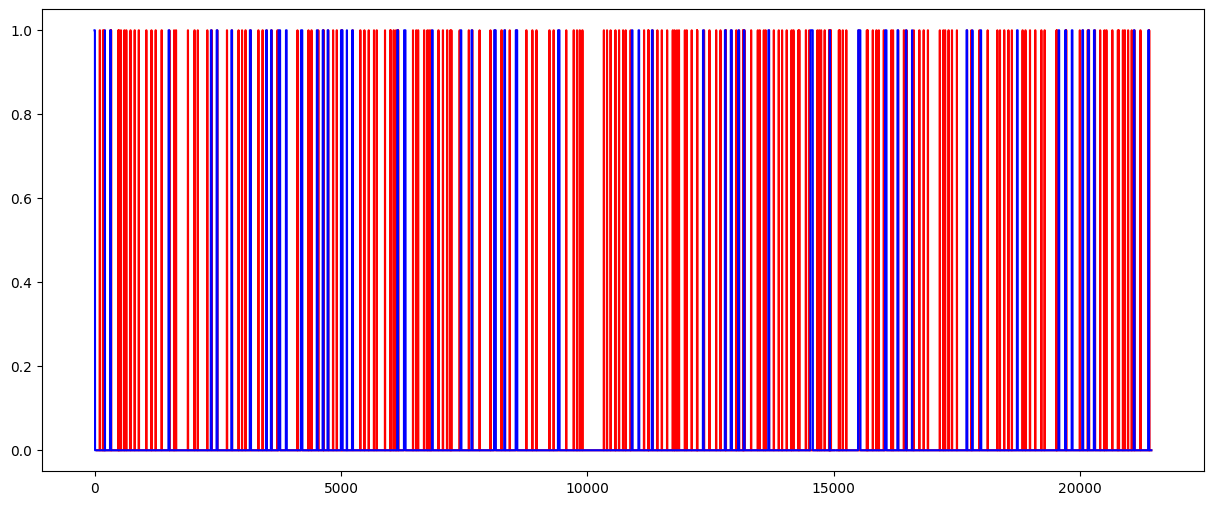

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset[:,2])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict_binary)+look_back] = trainPredict_binary
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset[:,2])
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict_binary)+(look_back*2)+1:len(dataset[:,2])-1] = testPredict_binary
# plot baseline and predictions
plt.plot(trainPredictPlot,'r')
plt.plot(testPredictPlot,'r')
plt.plot(dataset[:,-1],'b')
plt.show()